We are going to run the entire network on GRWL Tile. This will help us validate our width products and inspect some of the connectivity that we are getting using our methodology.

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pyproj
import geopandas as gpd
from rasterio import features
from rasterio.warp import transform_bounds
import scipy.ndimage as nd
from orinoco import filter_binary_array_by_min_size, polygonize_array_to_shapefile, get_cropped_profile
from tqdm import tqdm
import scipy.ndimage as nd
from skimage import measure

# Specify the GRWL Directory

The data we have lies in the following directory structure:

+ Centerlines: `grwl_data/centerlines/<tile_name>.tif`
+ Mask: `grwl_data/masks/<tile_name>.tif`

In [2]:
tile_name = 'NR08'
grwl_data = Path('grwl_data')
grwl_data.exists()

True

# Create a Tile Directory for Output Proudcts

We use the tile name to create a directory for our products.

In [3]:
tile_dir = Path(f'out/{tile_name}')
tile_dir.mkdir(exist_ok=True, parents=True)

# Crop The Water Mask Data

Let's first inspect the data.

In [4]:
with rasterio.open(grwl_data/f'masks/{tile_name}.tif') as ds:
    water_mask = ds.read(1).astype(bool).astype(int)
    profile = ds.profile

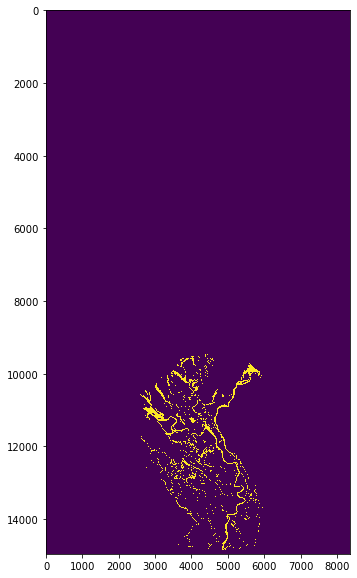

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(water_mask)

We manually find a window using numpy slices.

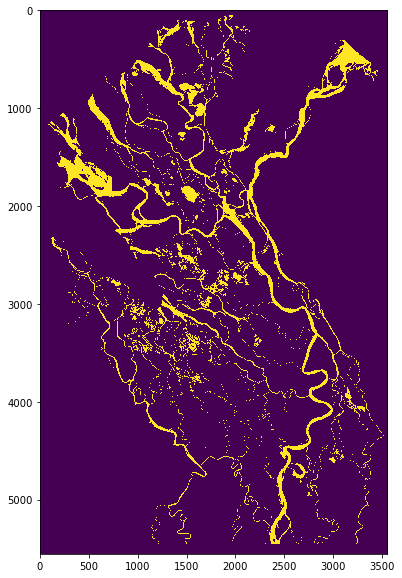

In [6]:
sy = np.s_[9400:]
sx = np.s_[2500:6050]

plt.figure(figsize=(10, 10))
plt.imshow(water_mask[sy, sx])

Having a satisfactory extent, we obtain the relevant geographic metadata and save the cropped area.

In [7]:
water_mask_c = water_mask[sy, sx]
profile_c = get_cropped_profile(profile, sx, sy)

with rasterio.open(tile_dir/f'water_mask_{tile_name}.tif', 'w', **profile_c) as ds:
    ds.write(water_mask_c.astype('uint8'), 1)

# Initialization Mask

We use this hydropolys [dataset](https://apps.gis.ucla.edu/geodata/dataset/world_water_bodies/resource/a6b40af0-84cb-40ce-b1c5-b024527a6943). This is a large dataset and we put it on an external hard drive.

Update your path accordingly.

In [8]:
water_body_shapefile = Path('/Volumes/BigData/river_data/hydropolys')
water_body_shapefile.exists()

True

We utilize rasterio's [`rasterize`](https://rasterio.readthedocs.io/en/latest/topics/features.html#burning-shapes-into-a-raster) to transalte the ocean geometry from the dataset above.

In [9]:
def translate_one(geometry, profile):
    shapes = [(geometry, 1)]
    out_arr = np.zeros((profile['height'], profile['width']))
    burned = features.rasterize(shapes=shapes,
                                out=out_arr,
                                transform=profile['transform'],
                                all_touched=True)
    return burned

We obtain the bounds of our dataset and use this to read a subset of the large shapefile consisting of global waterbodies. Then we translate the shapefile into a raster.

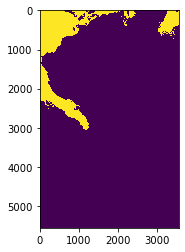

In [10]:
with rasterio.open(tile_dir/f'water_mask_{tile_name}.tif') as ds:
    bounds = ds.bounds
    crs = str(ds.crs).lower()
    profile = ds.profile
bounds_4326 = transform_bounds(crs, 'epsg:4326', *bounds)
oceanline_df = gpd.read_file(water_body_shapefile, bbox=bounds_4326).to_crs({'init':crs})
oceanline_df = oceanline_df[oceanline_df['TYPE'] == 'Ocean or Sea'].copy()
ocean_geometry = oceanline_df.geometry.unary_union.buffer(1e-9)
ocean_mask = translate_one(ocean_geometry, profile)
plt.imshow(ocean_mask)

We save the raster to our product directory.

In [11]:
with rasterio.open(tile_dir/f'ocean_mask_{tile_name}.tif', 'w', **profile) as ds:
    ds.write(ocean_mask.astype('uint8'), 1)